# Deep Q-Network (DQN) on Atari Breakout

This notebook implements the Deep Q-Network (DQN) algorithm as described in the paper **"Playing Atari with Deep Reinforcement Learning" (Mnih et al., NIPS 2013)**.

We utilize `gymnasium` for the environment and `torch` for the neural network.

## Paper References
*   **Architecture**: Convolutional Neural Network (16 filters -> 32 filters -> 256 FC -> Output).
*   **Preprocessing**: Grayscale, 84x84 resizing, Frame Skipping (k=4), Frame Stacking (4 frames).
*   **Algorithm**: Q-Learning with Experience Replay.

## Setup

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import ale_py
import matplotlib.pyplot as plt
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation, TransformReward

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Register ALE environments
gym.register_envs(ale_py)


SEED = 42

# Python + NumPy
random.seed(SEED)
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)

Using device: cuda


## 1. Environment Setup

We use the specific wrappers to match the DeepMind preprocessing pipeline:
1.  `AtariPreprocessing`: Handles grayscale conversion, resizing to 84x84, and frame skipping (4).
2.  `TransformReward`: Clips rewards to {-1, 0, 1} to stabilize training.
3.  `FrameStack`: Stacks the last 4 frames to provide temporal context to the agent.

Observation shape: (4, 84, 84)
Action space: 4


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


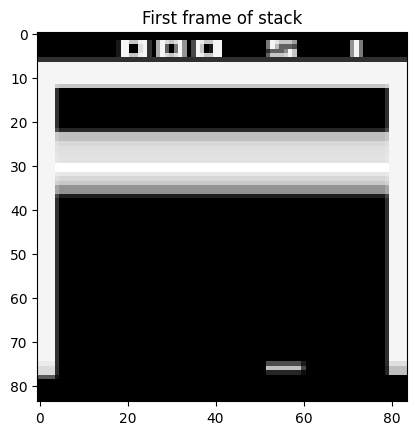

In [3]:
def make_env(render_mode=None):
    # full_action_space=False limits actions to [NOOP, FIRE, RIGHT, LEFT]
    env = gym.make("ALE/Breakout-v5", render_mode=render_mode, full_action_space=False, repeat_action_probability=0, frameskip=1)
    
    env = AtariPreprocessing(
        env, 
        screen_size=84, 
        grayscale_obs=True, 
        frame_skip=4,
        scale_obs=False  # We scale inside the model to save memory in replay buffer
    )
    
    # Clip rewards to sign (-1, 0, 1)
    env = TransformReward(env, lambda r: float(np.sign(r)))
    
    # Stack 4 frames
    env = FrameStackObservation(env, 4)
    return env

# Test environment
env = make_env()
obs, _ = env.reset()
print(f"Observation shape: {obs.shape}")
print(f"Action space: {env.action_space.n}")

# Visualize a stacked frame
plt.imshow(obs[0], cmap='gray')
plt.title("First frame of stack")
plt.show()

## 2. Model Architecture (NIPS 2013)

We implement the exact architecture specified in the 2013 paper:
*   Input: $84 	imes 84 	imes 4$
*   Conv1: 16 filters, $8 	imes 8$, stride 4, ReLU
*   Conv2: 32 filters, $4 	imes 4$, stride 2, ReLU
*   FC1: 256 units, ReLU
*   Output: `n_actions` linear units

In [4]:
class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU()
        )
        
        # Calculate FC input size
        # 84x84 -> (stride 4) -> 21x21
        # 21x21 -> (stride 2) -> 9x9 (technically 10x10 depending on padding, let's verify)
        # PyTorch Conv2d defaults to valid padding usually, but let's check dynamic size or calculate:
        # Conv1: floor((84 - 8)/4 + 1) = 20
        # Conv2: floor((20 - 4)/2 + 1) = 9
        # Final: 32 * 9 * 9
        
        self.fc_input_dim = 32 * 9 * 9
        
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        # x shape: [batch, 4, 84, 84]
        # Normalize to [0, 1]
        x = x.float() / 255.0
        
        x = self.conv(x)
        x = x.view(x.size(0), -1) # Flatten
        return self.fc(x)

## 3. Replay Memory

We use a cyclic buffer to store transitions `(state, action, reward, next_state, done)`.

**Note**: The paper uses 1,000,000 frames. Storing 1M frames of 84x84x4 takes substantial RAM (~28GB uncompressed). For this notebook demonstration, we use a smaller buffer (e.g., 50,000) or rely on your machine's available RAM.

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Compress state to uint8 if not already to save RAM
        # Gymnasium LazyFrames are good, but if we cast to numpy, ensure uint8
        state = np.array(state, dtype=np.uint8)
        next_state = np.array(next_state, dtype=np.uint8)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        
        return (
            np.array(state),
            np.array(action),
            np.array(reward, dtype=np.float32),
            np.array(next_state),
            np.array(done, dtype=np.uint8)
        )
    
    def __len__(self):
        return len(self.buffer)

## 4. Training Setup

### Hyperparameters (NIPS 2013 aligned)
*   **Batch Size**: 32
*   **Gamma**: 0.99
*   **Replay Memory**: 100,000 (Reduced from 1M for notebook safety)
*   **Start Epsilon**: 1.0
*   **End Epsilon**: 0.1
*   **Epsilon Decay Steps**: 1,000,000 frames
*   **Optimizer**: RMSProp

In [6]:
# Hyperparameters
frame_skip = 4
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY_STEPS = 250_000 * frame_skip
MEMORY_SIZE = 80_000 * frame_skip  # Adjust based on RAM
LEARNING_RATE = 0.00025
TOTAL_FRAMES = 1_000_000 * frame_skip # Total training frames (Paper did 10M)
START_LEARNING = 8_000 * frame_skip # Warmup steps before training starts

env = make_env()
n_actions = env.action_space.n

policy_net = DQN(n_actions).to(device)
# Note: NIPS 2013 didn't use a separate target net, but it froze weights for the target calculation.
# In modern PyTorch, we usually just clone the network or use the policy net with torch.no_grad()
# for the target calculation. 
# To strictly adhere to "parameters from previous iteration are held fixed", 
# we calculate targets using the current network detached from graph.
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

TARGET_UPDATE = 10000

optimizer = optim.RMSprop(policy_net.parameters(), lr=LEARNING_RATE, alpha=0.95, eps=0.01)
memory = ReplayBuffer(MEMORY_SIZE)

steps_done = 0

def noop_start(env, max_noops=30):
    noops = random.randint(1, max_noops)
    obs, _ = env.reset()
    for _ in range(noops):
        obs, _, terminated, truncated, _ = env.step(0)
        if terminated or truncated:
            obs, _ = env.reset()
    return obs

def select_action(state, eps):
    if random.random() < eps:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            # State to tensor
            state_t = torch.tensor(state, device=device).unsqueeze(0)
            q_values = policy_net(state_t)
            return q_values.argmax().item()

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    state, action, reward, next_state, done = memory.sample(BATCH_SIZE)
    
    state_t = torch.tensor(state, device=device)
    action_t = torch.tensor(action, device=device).unsqueeze(1)
    reward_t = torch.tensor(reward, device=device)
    next_state_t = torch.tensor(next_state, device=device)
    done_t = torch.tensor(done, device=device, dtype=torch.float32)

    # Compute Q(s, a)
    q_values = policy_net(state_t).gather(1, action_t)

    # Compute V(s') = max Q(s', a')
    # Using the same network for targets (NIPS 2013 style)
    with torch.no_grad():
        next_q_values = target_net(next_state_t).max(1)[0]
    
    # Compute target: y = r + gamma * max Q(s', a') * (1 - done)
    expected_q_values = reward_t + (GAMMA * next_q_values * (1 - done_t))

    # Loss
    loss = nn.functional.mse_loss(q_values.squeeze(), expected_q_values)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

## 5. Training Loop

In [7]:
from tqdm import tqdm

all_rewards = []
losses = []
episode_reward = 0
state = noop_start(env)

best = 0

bar = tqdm(range(TOTAL_FRAMES))
for step in bar:
    # Epsilon decay
    epsilon = np.interp(step * frame_skip, [0, EPS_DECAY_STEPS], [EPS_START, EPS_END])
    
    action = select_action(state, epsilon)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    
    memory.push(state, action, reward, next_state, done)
    state = next_state
    episode_reward += reward
    
    if done:
        #state, _ = env.reset()
        state = noop_start(env)
        all_rewards.append(episode_reward)
        best = max(episode_reward, best)
        bar.set_description(f"step: {step}, reward: {episode_reward}, eps: {epsilon:.3f}, reward: {(episode_reward, best)}")
        #print(f"Step {step}, Reward: {episode_reward}, Epsilon: {epsilon:.3f}")
        episode_reward = 0
    
    # Training step
    if step % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    if step > START_LEARNING:
        loss = optimize_model()
        if loss is not None:
            losses.append(loss)
            
    if step % 100000 == 0 and step > 0:
        torch.save(target_net.state_dict(), f"dqn_breakout_{step}.pth")


torch.save(target_net.state_dict(), f"dqn_breakout_{TOTAL_FRAMES}.pth")
env.close()
print("Training Complete")

step: 3999366, reward: 17.0, eps: 0.100, reward: (17.0, 85.0): 100%|██████████████████████████████████████████████████████████████████████████| 4000000/4000000 [3:15:38<00:00, 340.76it/s]

Training Complete


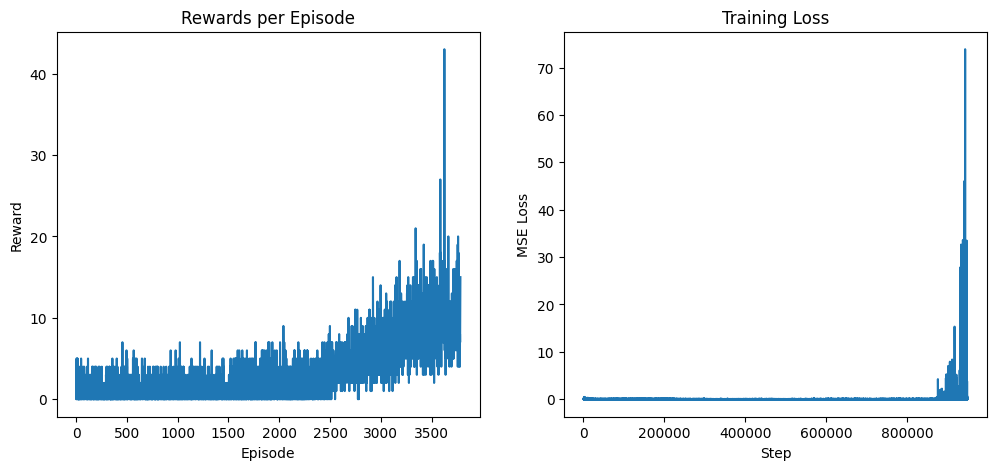

In [25]:
# Plotting results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(all_rewards)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1,2,2)
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.show()

In [33]:
import glob
from gymnasium.wrappers import RecordVideo

def make_env_for_video(video_folder):
    # full_action_space=False limits actions to [NOOP, FIRE, RIGHT, LEFT]
    env = gym.make("ALE/Breakout-v5", render_mode="rgb_array", full_action_space=False, repeat_action_probability=0, frameskip=1)
    
    # Wrap with RecordVideo to capture the episode
    # episode_trigger=lambda x: True records every episode (we'll only run one)
    if video_folder:
        env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True, disable_logger=False)
    
    env = AtariPreprocessing(
        env, 
        screen_size=84, 
        grayscale_obs=True, 
        frame_skip=4,
        scale_obs=False  # We scale inside the model to save memory in replay buffer
    )
    
    # Clip rewards to sign (-1, 0, 1)
    env = TransformReward(env, lambda r: float(np.sign(r)))
    
    # Stack 4 frames
    env = FrameStackObservation(env, 4)
    return env


print(f"Using device: {device}")

# Find the latest checkpoint
checkpoints = glob.glob("dqn_breakout_900000.pth")
if not checkpoints:
    print("No checkpoints found!")


# Sort by step count (assuming filename format dqn_breakout_{step}.pth)
# We need to extract the number to sort correctly
def extract_step(filename):
    try:
        return int(filename.split('_')[-1].split('.')[0])
    except ValueError:
        return 0

latest_checkpoint = max(checkpoints, key=extract_step)
print(f"Loading model from {latest_checkpoint}")

# Initialize environment
video_output_dir = "video_output"
env = make_env_for_video(video_output_dir)
env.metadata['render_fps'] = 320

n_actions = env.action_space.n

# Initialize model
model = DQN(n_actions).to(device)

# Load weights
state_dict = torch.load(latest_checkpoint, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Starting evaluation episode...")
obs, info = env.reset()
done = False
total_reward = 0

while not done:
    # Convert observation to tensor
    # Obs shape is (4, 84, 84), need (1, 4, 84, 84)
    state_t = torch.tensor(np.array(obs), device=device).unsqueeze(0)
    
    with torch.no_grad():
        # Select action with max Q-value (Greedy)
        q_values = model(state_t)
        action = q_values.argmax().item()
        
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated
    
env.close()
print(f"Episode finished. Total Reward: {total_reward}")
print(f"Video saved to {video_output_dir}")


Using device: cuda
Loading model from dqn_breakout_900000.pth
Starting evaluation episode...


/home/asq/epita/rl/dqn-breakout/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/asq/epita/rl/dqn-breakout/video_output folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
frame_index:  13%|███████████████▏                                                                                                       | 13745/108001 [08:59<15:28, 101.54it/s, now=None]

MoviePy - Building video /home/asq/epita/rl/dqn-breakout/video_output/rl-video-episode-0.mp4.
MoviePy - Writing video /home/asq/epita/rl/dqn-breakout/video_output/rl-video-episode-0.mp4




frame_index:  13%|███████████████▏                                                                                                       | 13745/108001 [09:00<15:28, 101.54it/s, now=None]

MoviePy - Done !
MoviePy - video ready /home/asq/epita/rl/dqn-breakout/video_output/rl-video-episode-0.mp4
Episode finished. Total Reward: 16.0
Video saved to video_output


In [34]:
from IPython.display import Video
import os

Video("video_output/rl-video-episode-0.mp4")